#1) Download the  data

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kartik2112/fraud-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fraud-detection


In [2]:
import pandas as pd
import numpy as np

train = pd.read_csv('{0}/fraudTrain.csv'.format(path))
test = pd.read_csv('{0}/fraudTest.csv'.format(path))

#2a) Transform the data

1. Obtain the local time of day
  + account for local time zone
  + account for circularity of time with sine and cosine

2. Transform date of birth to age

3. **Normalize the data based on historical trasactions.**
  + transaction amount
  + time of day



In [3]:
#1) local transaction time

state_timezone_map = {
    'AL': 'America/Chicago',
    'AK': 'America/Anchorage',
    'AZ': 'America/Phoenix',       # No DST
    'AR': 'America/Chicago',
    'CA': 'America/Los_Angeles',
    'CO': 'America/Denver',
    'CT': 'America/New_York',
    'DE': 'America/New_York',
    'FL': 'America/New_York',      # Most of Florida
    'GA': 'America/New_York',
    'HI': 'Pacific/Honolulu',      # No DST
    'ID': 'America/Boise',         # Split between MT and PT
    'IL': 'America/Chicago',
    'IN': 'America/Indiana/Indianapolis',
    'IA': 'America/Chicago',
    'KS': 'America/Chicago',
    'KY': 'America/New_York',
    'LA': 'America/Chicago',
    'ME': 'America/New_York',
    'MD': 'America/New_York',
    'MA': 'America/New_York',
    'MI': 'America/Detroit',
    'MN': 'America/Chicago',
    'MS': 'America/Chicago',
    'MO': 'America/Chicago',
    'MT': 'America/Denver',
    'NE': 'America/Chicago',
    'NV': 'America/Los_Angeles',
    'NH': 'America/New_York',
    'NJ': 'America/New_York',
    'NM': 'America/Denver',
    'NY': 'America/New_York',
    'NC': 'America/New_York',
    'ND': 'America/Chicago',
    'OH': 'America/New_York',
    'OK': 'America/Chicago',
    'OR': 'America/Los_Angeles',
    'PA': 'America/New_York',
    'RI': 'America/New_York',
    'SC': 'America/New_York',
    'SD': 'America/Chicago',
    'TN': 'America/Chicago',
    'TX': 'America/Chicago',
    'UT': 'America/Denver',
    'VT': 'America/New_York',
    'VA': 'America/New_York',
    'WA': 'America/Los_Angeles',
    'WV': 'America/New_York',
    'WI': 'America/Chicago',
    'WY': 'America/Denver'
}

def local_time(df):
    df = df.copy()

    df['timezone'] = df['state'].map(state_timezone_map)
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['trans_date_trans_time'] = df['trans_date_trans_time'].dt.tz_localize('UTC')

    local_dt = df.apply(
        lambda row: row['trans_date_trans_time'].tz_convert(row['timezone']) if pd.notnull(row['timezone']) else pd.NaT,
        axis=1
    )

    time_in_seconds = local_dt.apply(
        lambda dt: dt.hour * 3600 + dt.minute * 60 + dt.second if pd.notnull(dt) else None
    )

    seconds_in_day = 24 * 60 * 60
    seconds_norm = time_in_seconds / seconds_in_day

    #acount for circularity of time of day
    ##i.e. 12:59pm is close to 1pm
    df['time_sin'] = np.sin(2 * np.pi * seconds_norm)
    df['time_cos'] = np.cos(2 * np.pi * seconds_norm)

    return df[['time_sin', 'time_cos']]


train[['time_sin', 'time_cos']] = local_time(train)
test[['time_sin', 'time_cos']] = local_time(test)

In [4]:
#2) Transform date of birth to age in years

def get_age(df):

    today = pd.Timestamp('2020-01-01')
    #could have reference 'today' be transaction time but doesn't matter much because transactions are all within two years

    df['dob'] = pd.to_datetime(df['dob'])
    df['age'] = df['dob'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))

    return df['age']

train['age'] = get_age(train)
test['age'] = get_age(test)

In [5]:
#3) calculate z-score based on historical transaction trends

def log_zscore(df, col):
    df = df.copy()

    df['log_col'] = np.log(df[col])  # log-transform because distribution of 'amt' looks more log-normal than normal
    df['std_col'] = df.groupby(['first', 'last'])['log_col'].transform('std')
    df['mean_col'] = df.groupby(['first', 'last'])['log_col'].transform('mean')

    df['z_col'] = (df['log_col'] - df['mean_col']) / df['std_col']

    return df[['z_col']]


def zscore(df, col):
    df = df.copy()

    mean_ = df.groupby(['first', 'last'])[col].transform('mean')
    std_ = df.groupby(['first', 'last'])[col].transform('std')

    df['z_col'] = (df[col] - mean_) / std_

    return df[['z_col']]

#account for circularity of time. i.e. 11:59pm is close to 00:01am
def time_zscore(df):
    mean_sin = df['time_sin'].mean()
    mean_cos = df['time_cos'].mean()

    norm = np.sqrt(mean_sin**2 + mean_cos**2) #also the radius R
    circular_std = np.sqrt(-2 * np.log(norm))

    mean_sin /= norm
    mean_cos /= norm

    new_sin = df['time_sin'] * mean_cos - df['time_cos'] * mean_sin
    new_cos = df['time_sin'] * mean_sin + df['time_cos'] * mean_cos

    # arctan2 is in radians, range [-π, π]
    return np.arctan2(new_sin, new_cos) / circular_std


train['amt_zscore'] = log_zscore(train, 'amt')
test['amt_zscore'] = log_zscore(test, 'amt')

train['time_zscore'] = time_zscore(train)
test['time_zscore'] = time_zscore(test)

#2b) Transform the data

###Drop non-zscored amt and time to avoid collinearity.

In [6]:
#columns to be removed
no_need = ['cc_num', 'Unnamed: 0','street', 'city',  'dob','job','first',
           'last','trans_num','trans_date_trans_time', 'lat', 'long', 'merch_lat',
           'merch_long', 'unix_time','merchant','state']
more = ['amt', 'time_sin', 'time_cos']
no_need = no_need+more

sparse_train = train.drop(columns = no_need)
sparse_train['gender'] = sparse_train['gender'].astype('category')  #XGBoost can handle categorical variable
sparse_train['category'] = sparse_train['category'].astype('category')

sparse_test = test.drop(columns = no_need)
sparse_test['gender'] = sparse_test['gender'].astype('category')
sparse_test['category'] = sparse_test['category'].astype('category')

#setup features (X) and the classification (y)
y_train, X_train  = sparse_train['is_fraud'], sparse_train.drop(columns='is_fraud')
y_test, X_test = sparse_test['is_fraud'], sparse_test.drop(columns='is_fraud')

#3) Explore the data

In [7]:
print(sparse_train.columns)
print(sparse_train.dtypes)

N_observations, N_features = X_train.shape
print('Number of Observations: ' + str(N_observations))
print('Number of Features: ' + str(N_features))

#sparse_train.head()
#sparse_train.describe()

Index(['category', 'gender', 'zip', 'city_pop', 'is_fraud', 'age',
       'amt_zscore', 'time_zscore'],
      dtype='object')
category       category
gender         category
zip               int64
city_pop          int64
is_fraud          int64
age               int64
amt_zscore      float64
time_zscore     float64
dtype: object
Number of Observations: 1296675
Number of Features: 7


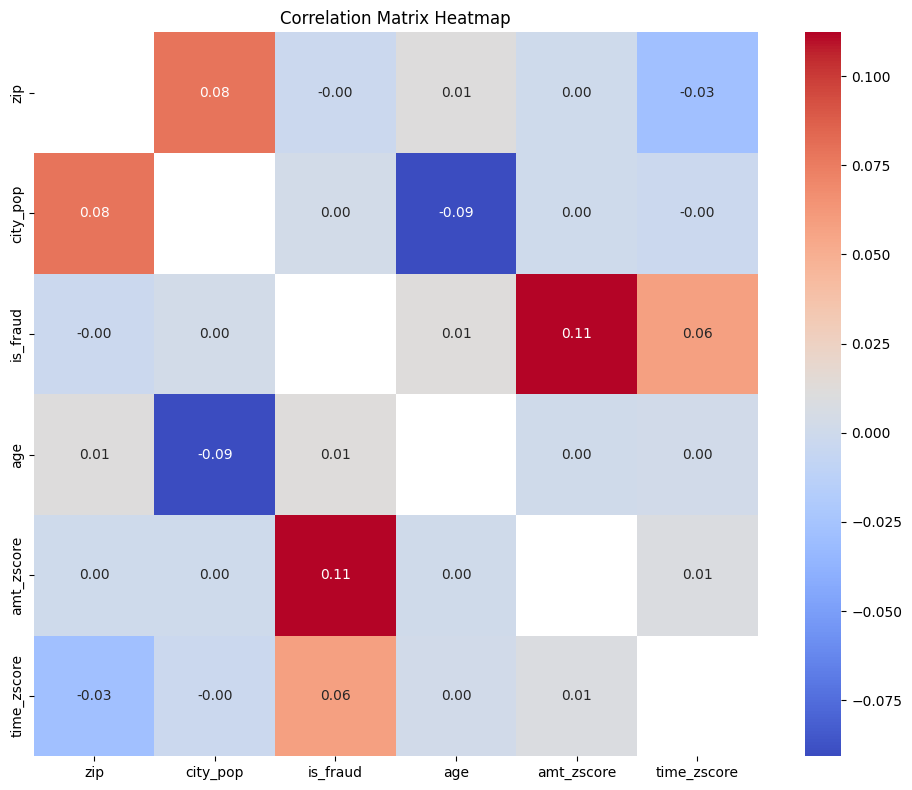

In [8]:
#Plot correlation matrix for numerical features

import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns
numeric_df = sparse_train.select_dtypes(include='number')

# Compute correlation matrix
correlation_matrix = numeric_df.corr()
np.fill_diagonal(correlation_matrix.values, np.nan) #remove diagonal from consideration

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()


One concerning result is that correlations with zscored features and fraud are not as strong as the original features and fraud.

#4) Alright, time for some modeling!

####We will focus on using a XGBoost classifier.



In [9]:
#Use gpus to train XGB on the transformed data

from xgboost import XGBClassifier
from sklearn.metrics import classification_report


# Train XGBoost classifier
clf_xgb = XGBClassifier(enable_categorical=True, device='cuda',tree_method='hist', eval_metric='logloss') #use gpu
clf_xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = clf_xgb.predict(X_test)

print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.88      0.63      0.73      2145

    accuracy                           1.00    555719
   macro avg       0.94      0.81      0.87    555719
weighted avg       1.00      1.00      1.00    555719



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:57:59] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [10]:
#Train XGB on transformed data.
#Reweight model to make fraud cases equal to non-fraud


#find reweight
counts = y_train.value_counts()
scale_pos_weight = counts.get(0,0)/counts.get(1,0)  #use this to upweight fraud cases


# Train XGBoost classifier
clf_xgb = XGBClassifier(enable_categorical=True, device='cuda',tree_method='hist', eval_metric='logloss', scale_pos_weight=scale_pos_weight)
clf_xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = clf_xgb.predict(X_test)

print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       1.00      0.99      0.99    553574
           1       0.20      0.88      0.33      2145

    accuracy                           0.99    555719
   macro avg       0.60      0.94      0.66    555719
weighted avg       1.00      0.99      0.99    555719



Results are poorer with zscored features. Thus, we do not include transaction history in our final chosen model since it surprisingly seems unhelpful in fraud prediction.

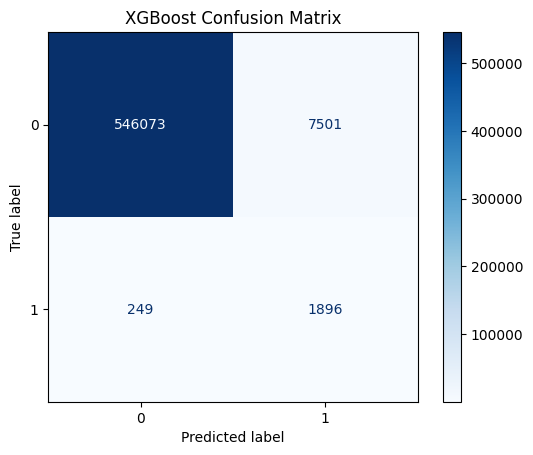

In [11]:
#Get greater granularity by plotting the confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("XGBoost Confusion Matrix")
plt.show()


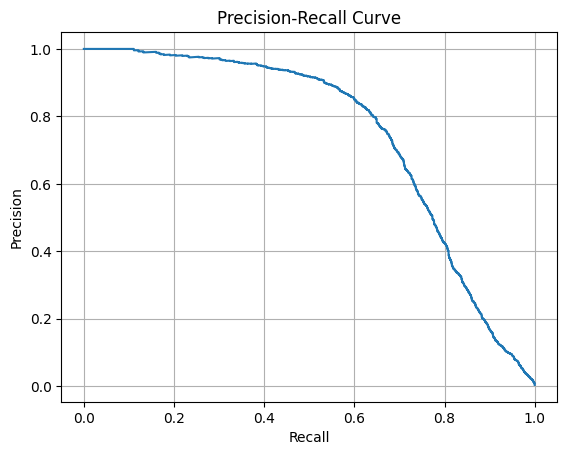

PR AUC: 0.7459
fraud rate: 0.0039
our model is 193.2x better than a random guesser.


In [12]:
#consider different thresholds (besides 0.5) to delineate fraud and legitimate transactions

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

y_prob = clf_xgb.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()
pr_auc = auc(recall, precision)

counts = y_test.value_counts()
fraud_rate = counts.get(1,0)/(counts.get(0,0)+counts.get(1,0))
print(f"PR AUC: {pr_auc:.4f}")
print("fraud rate: {:.4f}".format(fraud_rate))


print(f"our model is {pr_auc/fraud_rate:.1f}x better than a random guesser.")

#5) Interpret the model using Shap

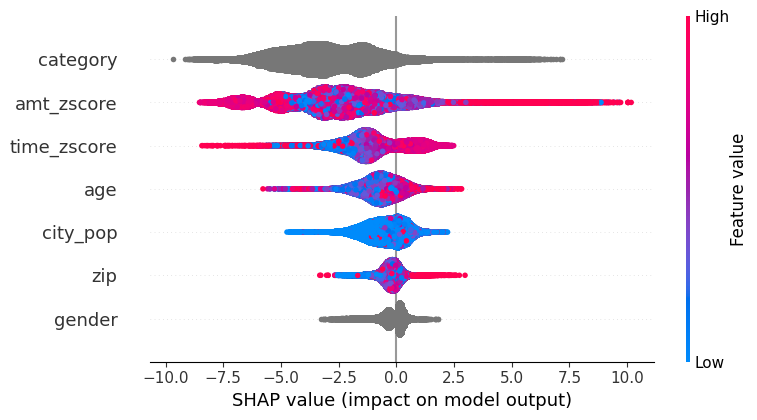

In [13]:
#Plot feature importance

import xgboost as xgb
import shap

# Get Booster object
booster = clf_xgb.get_booster()

# Convert input to DMatrix
dtest = xgb.DMatrix(X_test, enable_categorical=True)

# Get SHAP values (includes bias term as last column)
shap_values = booster.predict(dtest, pred_contribs=True)


# Remove the last column (bias term)
shap_values_no_bias = shap_values[:, :-1]

# Use the feature names from your training data (optional)
feature_names = X_test.columns.tolist()#[f"f{i}" for i in range(X_test.shape[1])]

# SHAP summary plot (dot)
shap.summary_plot(shap_values_no_bias, X_test, feature_names=feature_names)

Interesting that category surposes amt when it is zscored.

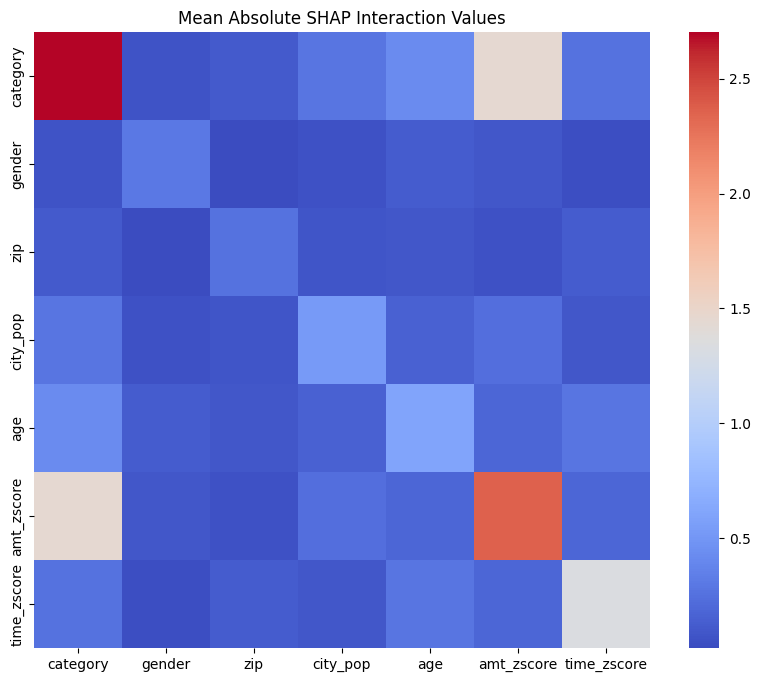

In [14]:
#Compare feature importance (diagonal) with respect to feature-feature interactions (off-diagonal)

# Get SHAP values (includes bias term as last column)
shap_intxn_values = booster.predict(dtest, pred_interactions=True)

# Remove the last column (bias term)
shap_intxn_values_no_bias = shap_intxn_values[:, :-1, :-1]

# Compute mean absolute interaction values across all samples
mean_abs_interactions = np.abs(shap_intxn_values_no_bias).mean(axis=0)

# Convert to DataFrame
df = pd.DataFrame(mean_abs_interactions, index=X_test.columns, columns=X_test.columns)

# Plot heatmap of interaction strengths
plt.figure(figsize=(10, 8))
sns.heatmap(df, cmap="coolwarm", square=True)
plt.title("Mean Absolute SHAP Interaction Values")
plt.show()

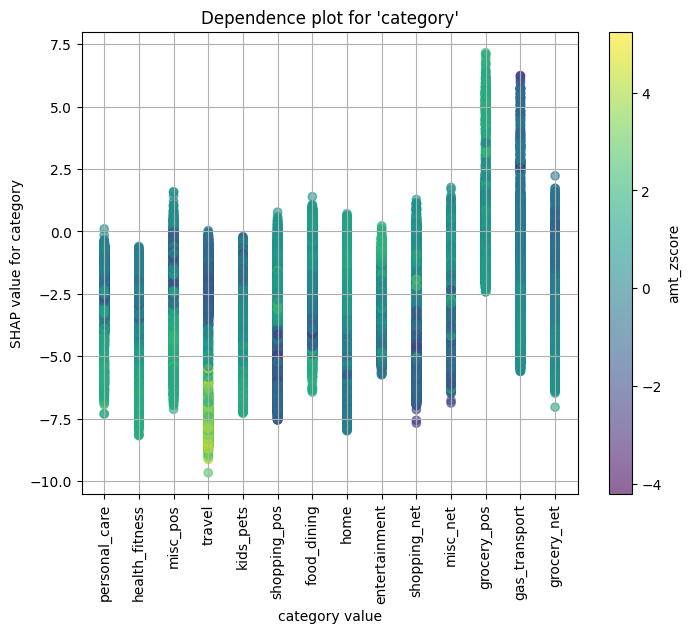

In [18]:
#plot dependency plot for transaction plot for category

# Pick a feature to plot
feature = 'category'  # or whatever column you want to explore
color_by = 'amt_zscore'

# Get the SHAP values for that feature across all samples
feature_index = X_test.columns.get_loc(feature)
shap_vals_feature = shap_values[:, feature_index]

# Plot dependence: SHAP value vs feature value
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_test[feature], shap_vals_feature, alpha=0.6, c=X_test[color_by], cmap='viridis') #can additionally color by a third variable, maybe try amt
plt.xlabel(f"{feature} value")
plt.xticks(rotation=90)
plt.ylabel(f"SHAP value for {feature}")
plt.title(f"Dependence plot for '{feature}'")

cbar = plt.colorbar(scatter)
cbar.set_label("{0}".format(color_by))
plt.grid(True)
plt.show()
